In [1]:
#Import libraries

from sklearn import metrics
import pandas as pd
import numpy as np
from pyparsing import col
from requests import head
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from torch import rand
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler


In [2]:
#Read in data 

#User data
df = pd.read_csv('udata.txt', sep='\t', header=None)
df.columns = ['user_id', 'item_id', 'rating', 'timestamp']

#Users
users = pd.read_csv('uuser.txt', sep='|', header=None)
users.columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']

#genre data
genre = pd.read_csv('ugenre.txt', sep='|', header=None)
genre.columns = ['genre', 'genre_id']

#occupation data
job = pd.read_csv('uoccupation.txt', sep='|', header=None)
job.columns = ['occupation']
job = job.reset_index().rename(columns={'index': 'job'})

#other items
items = pd.read_csv('uitem.txt', sep='|', header=None)
items.columns = ['movie_id', 'movie_title', 'video_release_date', 'imdb_url', 'unknown', 'Action', 'Adventure', 'Animation','Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film_Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Thriller', 'War', 'Western']

In [60]:
#Combine/clean data

data = df.merge(users, how='left', on = 'user_id').merge(job, how = 'left', on='occupation').merge(items, how='left', left_on='item_id', right_on='movie_id')
data[data.Western.isna()]
data = data[data.Western.notna()].astype({'Western': 'int'})
data.gender.unique()
data['gender_id'] = np.where(data.gender == 'M', 0, 1)

#subset data to movies with over 100 reviews and reviewers with over 5 reviews
data = data[data.groupby("item_id")["item_id"].transform("size")>200]
data = data[data.groupby("user_id")["user_id"].transform("size")>10]


Text(0.5, 1.0, 'Rating Distribution')

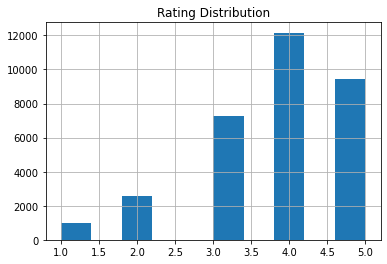

In [4]:
#Look at response variable distribution
data.hist(column = 'rating')
plt.title("Rating Distribution")

Text(0.5, 1.0, 'Age Distribution')

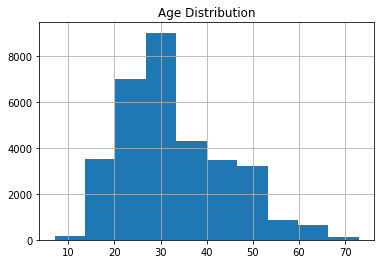

In [5]:
#Glance at other distributions

data.hist(column = 'age')
plt.title("Age Distribution")

Text(0, 0.5, 'Count')

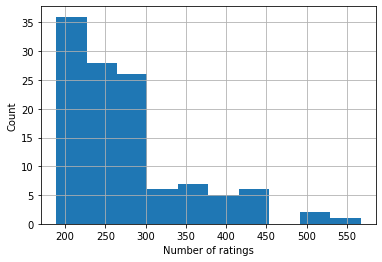

In [6]:
# How many ratings do movies have?
data.groupby('item_id')['rating'].count().hist()
plt.xlabel("Number of ratings")
plt.ylabel("Count")

In [7]:
#Convert to long format data for genre for correlation analysis

dataLong = pd.melt(data, id_vars = ['user_id', 'item_id', 'rating', 'timestamp', 'age', 'gender',
                        'occupation', 'zip_code', 'job', 'movie_id', 'movie_title','video_release_date', 'imdb_url',
                               'gender_id'],
        var_name = "genre",
       value_name = "values")
dataLong = dataLong.loc[dataLong['values'] == 1]
dataLong = dataLong.drop("values", 1)

correlation_matrix = dataLong.corr()
correlation_matrix

,user_id,item_id,rating,timestamp,age,job,movie_id,gender_id
user_id,1.000000,0.004230,-0.019344,0.009117,-0.083715,0.103159,0.004230,0.014287
item_id,0.004230,1.000000,-0.114126,0.038692,0.011086,-0.000194,1.000000,0.003130
rating,-0.019344,-0.114126,1.000000,-0.035430,-0.014042,-0.025793,-0.114126,-0.015383
timestamp,0.009117,0.038692,-0.035430,1.000000,0.149947,0.055165,0.038692,0.027137
age,-0.083715,0.011086,-0.014042,0.149947,1.000000,-0.351549,0.011086,-0.024447
job,0.103159,-0.000194,-0.025793,0.055165,-0.351549,1.000000,-0.000194,-0.026429
movie_id,0.004230,1.000000,-0.114126,0.038692,0.011086,-0.000194,1.000000,0.003130
gender_id,0.014287,0.003130,-0.015383,0.027137,-0.024447,-0.026429,0.003130,1.000000


In [61]:
# split into train/test for kNN

features = ['rating', 'age', 'gender_id', 'job', 'unknown', 'Action', 'Adventure', 'Animation','Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film_Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Thriller', 'War', 'Western']

data_x = data[features].drop(columns=['rating'])
data_y = data[['rating']]

train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.33, random_state=123)



In [27]:
scaler = StandardScaler()
scaler.fit(train_x)

train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

In [10]:
# knn regression, find best k value

errors = list()
for i in range(1,20):
    knn_model = KNeighborsClassifier(n_neighbors=i)
    knn_model.fit(train_x, train_y.values.ravel())

    test_preds = knn_model.predict(test_x)
    mse = mean_squared_error(test_y, test_preds)
    errors.append(mse)



Text(0, 0.5, 'mse')

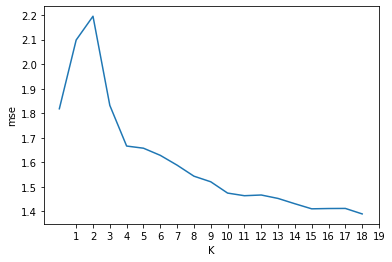

In [11]:
plt.plot(errors)
plt.xticks(range(1,20))
plt.xlabel("K")
plt.ylabel("mse")

In [62]:
classifier = KNeighborsClassifier(n_neighbors= 15)
classifier.fit(train_x, train_y.values.ravel())
y_pred = classifier.predict(test_x)


In [63]:
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           1       0.21      0.02      0.03       326
           2       0.14      0.03      0.05       871
           3       0.27      0.25      0.26      2305
           4       0.41      0.56      0.48      4074
           5       0.40      0.37      0.39      3121

    accuracy                           0.38     10697
   macro avg       0.29      0.24      0.24     10697
weighted avg       0.35      0.38      0.35     10697



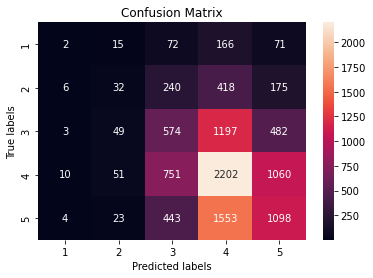

In [15]:
ax= plt.subplot()
cm = confusion_matrix(test_y, y_pred)
sns.heatmap(cm, annot=True, fmt='g')

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['1','2','3','4','5']); ax.yaxis.set_ticklabels(['1','2','3','4','5']);

In [92]:
#Top 10 movies

dataNew = data.loc[test_x.index.values.tolist(),:]
dataNew["predictions"] = y_pred

topMovies = dataNew.groupby("movie_title")["predictions"].mean()
topMovies = topMovies.sort_values(ascending = False).head(n = 10)
topMovies

movie_title
GoodFellas (1990)                  4.465753
Godfather: Part II, The (1974)     4.424242
Empire Strikes Back, The (1980)    4.418033
Apocalypse Now (1979)              4.389610
Pulp Fiction (1994)                4.379562
Graduate, The (1967)               4.376623
Return of the Jedi (1983)          4.366279
Usual Suspects, The (1995)         4.341176
Seven (Se7en) (1995)               4.328947
Star Wars (1977)                   4.324324
Name: predictions, dtype: float64